# EMNIST digit classification

## Results of this model on MNIST test data: 
1. 0.22% test error rate with ensemble of 10 CNNs
2. 0.21% test error rate with ensemble of 6 selected CNNs
3. 0.26% test error rate for best single model (model was trained for a few more epochs)

## Results of this model on EMNIST test data: 
1. todo

In [1]:
%matplotlib inline

In [2]:
import keras
import numpy as np
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D
from keras.layers import Flatten, Lambda, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam as Adam

# try leaky relu
from keras.layers.advanced_activations import LeakyReLU

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1070 (CNMeM is enabled with initial size: 90.0% of memory, cuDNN 5103)


# Load MNIST dataset

In [47]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# store labels on test set for visualization
test_labels = y_test

In [3]:
rows = 28
cols = 28

# theano input shape
input_shape = (1, rows, cols)

In [ ]:
x_train.shape

In [ ]:
# vgg expects channels - here we have just one
x_train = x_train.reshape(x_train.shape[0], 1, 28, 28)
x_test = x_test.reshape(x_test.shape[0], 1, 28, 28)
x_train.shape

In [ ]:
# convert to float
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

# normalize
x_train /= 255
x_test /= 255

In [ ]:
y_train.shape

In [ ]:
# labels should be onehot encoded
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

y_train.shape

In [ ]:
y_train[:5]

# Load EMNIST dataset
Introduced by https://arxiv.org/abs/1702.05373v1 downloaded from https://www.nist.gov/itl/iad/image-group/emnist-dataset (Matlab format dataset). The matlab format dataset can be conveniently imported with scipy.io.loadmat.

In [4]:
from scipy import io as spio

In [5]:
emnist = spio.loadmat("datasets/matlab/emnist-digits.mat")

In [6]:
# load training dataset
X_train_emnist = emnist["dataset"][0][0][0][0][0][0]
X_train_emnist = X_train_emnist.astype(np.float32)

# load training labels
y_train_emnist = emnist["dataset"][0][0][0][0][0][1]

In [7]:
# load test dataset
X_test_emnist = emnist["dataset"][0][0][1][0][0][0]
X_test_emnist = X_test_emnist.astype(np.float32)

# load test labels
y_test_emnist = emnist["dataset"][0][0][1][0][0][1]

In [8]:
# store labels for visualization
train_labels_emnist = y_train_emnist
test_labels_emnist = y_test_emnist

In [9]:
X_train_emnist.shape

(240000, 784)

In [10]:
y_train_emnist.shape

(240000, 1)

In [11]:
# normalize
X_train_emnist /= 255
X_test_emnist /= 255

In [12]:
X_train_emnist

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [13]:
# reshape using matlab order
X_train_emnist = X_train_emnist.reshape(X_train_emnist.shape[0], 1, 28, 28, order="A")
X_test_emnist = X_test_emnist.reshape(X_test_emnist.shape[0], 1, 28, 28, order="A")

In [14]:
X_train_emnist.shape

(240000, 1, 28, 28)

In [15]:
y_train_emnist.shape

(240000, 1)

In [16]:
# labels should be onehot encoded
y_train_emnist = keras.utils.to_categorical(y_train_emnist, 10)
y_test_emnist = keras.utils.to_categorical(y_test_emnist, 10)

y_train_emnist.shape

(240000, 10)

### verify we have imported the data correctly

In [ ]:
# which sample to look at
samplenum = 5437

In [ ]:
import matplotlib.pyplot as plt

img = X_train_emnist[samplenum]

# visualize image
plt.imshow(img[0], cmap='gray')

In [ ]:
# show label for sample image
train_labels_emnist[samplenum][0]

# Use EMNIST dataset instead of MNIST

In [49]:
x_train = X_train_emnist
y_train = y_train_emnist

x_test = X_test_emnist
y_test = y_test_emnist

test_labels = test_labels_emnist

In [56]:
test_labels = test_labels.reshape(40000)

In [57]:
test_labels.shape

(40000,)

# Define model

In [18]:
# calculate mean and standard deviation
mean_px = x_train.mean().astype(np.float32)
std_px = x_train.std().astype(np.float32)

In [19]:
# function to normalize input data
def norm_input(x): return (x-mean_px)/std_px

In [20]:
# Batchnorm + dropout + data augmentation
def create_model():
    model = Sequential([
        Lambda(norm_input, input_shape=(1,28,28), output_shape=(1,28,28)),
        Conv2D(32, (3,3)),
        LeakyReLU(),
        BatchNormalization(axis=1),
        Conv2D(32, (3,3)),
        LeakyReLU(),
        MaxPooling2D(),
        BatchNormalization(axis=1),
        Conv2D(64, (3,3)),
        LeakyReLU(),
        BatchNormalization(axis=1),
        Conv2D(64, (3,3)),
        LeakyReLU(),
        MaxPooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512),
        LeakyReLU(),
        BatchNormalization(),
        Dropout(0.3),
        Dense(10, activation='softmax')
    ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Data augmentation
Use keras's data augmentation.

In [21]:
batch_size = 512

In [22]:
from keras.preprocessing.image import ImageDataGenerator

In [23]:
gen = ImageDataGenerator(rotation_range=12, width_shift_range=0.1, shear_range=0.3,
                        height_shift_range=0.1, zoom_range=0.1, data_format='channels_first')
batches = gen.flow(x_train, y_train, batch_size=batch_size)
test_batches = gen.flow(x_test, y_test, batch_size=batch_size)
steps_per_epoch = int(np.ceil(batches.n/batch_size))
validation_steps = int(np.ceil(test_batches.n/batch_size))

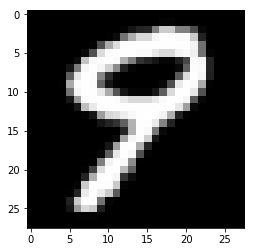

In [24]:
import matplotlib.pyplot as plt

# load ONE image from training set to display on screen
img = x_train[1]

# visualize original image
plt.imshow(img[0], cmap='gray')

In [25]:
# trick our generator into believing img has enough dimensions
# and get some augmented images for our single test image
img = np.expand_dims(img, axis=0)
aug_iter = gen.flow(img)

In [26]:
aug_img = next(aug_iter)[0].astype(np.float32)
aug_img.shape

(1, 28, 28)

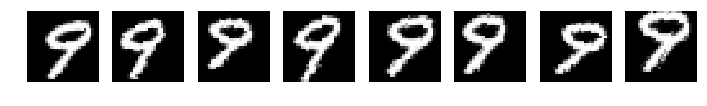

In [27]:
import matplotlib.pyplot as plt

# show augmented images
f = plt.figure(figsize=(12,6))
for i in range(8):
    sp = f.add_subplot(2, 26//3, i+1)
    sp.axis('Off')
    aug_img = next(aug_iter)[0].astype(np.float32)
    plt.imshow(aug_img[0], cmap='gray')

# Create models with saved weights

In [ ]:
models = []

for i in range(10):
    m = create_model()
    m.load_weights("weights/weights_leaky_relu_model_0.22_"+str(i)+'.pkl')
    models.append(m)

# Ensembling
Here we create ten models and fit them to our augmented data. We use the mean prediction from all ten classifiers as our final prediction. This should average out errors in our classifiers and enable us to predict with higher accuracy.

In [ ]:
# fit the model on batches with real-time data augmentation
def fit_model(m):
    m.fit_generator(batches, steps_per_epoch=steps_per_epoch, epochs=1, verbose=0,
                   validation_data=test_batches, validation_steps=validation_steps)
    m.optimizer.lr = 0.1
    m.fit_generator(batches, steps_per_epoch=steps_per_epoch, epochs=4, verbose=0,
                   validation_data=test_batches, validation_steps=validation_steps)
    m.optimizer.lr = 0.01
    m.fit_generator(batches, steps_per_epoch=steps_per_epoch, epochs=12, verbose=0,
                   validation_data=test_batches, validation_steps=validation_steps)
    m.optimizer.lr = 0.001
    m.fit_generator(batches, steps_per_epoch=steps_per_epoch, epochs=18, verbose=0,
                   validation_data=test_batches, validation_steps=validation_steps)
    return m

## Create and train ten models

In [ ]:
models = []

for i in range(10):
    print("Training model {}".format(i))
    m = fit_model(create_model())
    models.append(m)

In [ ]:
# train models some more if accuracy is not satisfying enough
for i, m in enumerate(models):
    m.optimizer.lr = 0.0001
    print("Model {}".format(i))
    m.fit_generator(batches, steps_per_epoch=steps_per_epoch, epochs=2,
                   validation_data=test_batches, validation_steps=validation_steps)

# Evaluate Model

In [28]:
eval_batch_size = 512

In [ ]:
# evaluate every model
evals = np.array([m.evaluate(x_test,y_test, batch_size=eval_batch_size) for m in models])

In [ ]:
# calculate mean from evaluations
evals.mean(axis=0)

In [ ]:
all_preds = np.stack([m.predict(x_test, batch_size=eval_batch_size) for m in models])

In [ ]:
all_preds.shape

In [ ]:
avg_preds = all_preds.mean(axis=0)
avg_preds.shape

In [ ]:
# display error rate in percent
(1 - keras.metrics.categorical_accuracy(y_test, avg_preds).eval().mean()) * 100

### Results of ensemble of 10 CNNs trained on MNIST dataset

1. 0.45250058174133301

# Show test error rate of every model separately

Results for .22 average error rate model weights (Model # / error rate)
1. 0.370001792908
2. 0.330001115799
3. 0.429999828339
4. 0.349998474121
5. 0.370001792908
6. 0.340002775192
7. 0.370001792908
8. 0.360000133514
9. 0.29000043869
10. 0.360000133514

In [ ]:
for i, m in enumerate(models):
    pred = np.array(m.predict(x_test, batch_size=eval_batch_size))
    print(i+1, (1 - keras.metrics.categorical_accuracy(y_test, pred).eval().mean()) * 100)

In [ ]:
# show accuracy of single model

# which model number to check
i = 8

In [ ]:
# calculate accuracy of a single model
pred = np.array(models[i].predict(x_test, batch_size=eval_batch_size))
print(i, (1 - keras.metrics.categorical_accuracy(y_test, pred).eval().mean()) * 100)

# Plot Training History

Here we create and train a single model from scratch to get a plot of the training history.

In [ ]:
# create and train a single model
m = create_model()
history = m.fit_generator(batches, steps_per_epoch=steps_per_epoch, epochs=10, verbose=0,
                         validation_data=test_batches, validation_steps=validation_steps)

Jason Brownlee's script to plot model training history:
https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

In [ ]:
import matplotlib.pyplot as plt

axes = plt.gca()
#axes.set_xlim([1,5])
#axes.set_ylim([0.2,1.0])

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Try evaluation only with best performing models
Ensemble with models 0,4,5,7,8,9 gives a test error rate of 0.21%. State of the art.

In [ ]:
best_model_numbers = [0,4,5,7,8,9]

In [ ]:
best_models = []

for i in best_model_numbers:
    best_models.append(models[i])

In [ ]:
# evaluate every model
evals = np.array([m.evaluate(x_test,y_test, batch_size=eval_batch_size) for m in best_models])

In [ ]:
# calculate mean from evaluations
evals.mean(axis=0)

In [ ]:
all_preds = np.stack([m.predict(x_test, batch_size=eval_batch_size) for m in best_models])

In [ ]:
all_preds.shape

In [ ]:
avg_preds = all_preds.mean(axis=0)
avg_preds.shape

In [ ]:
# display error rate in percent
(1 - keras.metrics.categorical_accuracy(y_test, avg_preds).eval().mean()) * 100

# Train single model some more

Select a single model, train for a few epochs, and check accuracy.

In [ ]:
# which model to train
i = 8

In [ ]:
# reload weights in case of overfitting
models[i].load_weights("weights/model_0.26.pkl")

In [ ]:
models[i].optimizer.lr = 0.0001
history = models[i].fit_generator(batches, steps_per_epoch=steps_per_epoch, epochs=1,
                   validation_data=test_batches, validation_steps=validation_steps)

In [ ]:
# calculate accuracy of a single model
pred = np.array(models[i].predict(x_test, batch_size=eval_batch_size))
print(i, (1 - keras.metrics.categorical_accuracy(y_test, pred).eval().mean()) * 100)

In [ ]:
models[i].save_weights("weights/weights_leaky_relu_model_0.2x"+str(i)+'.pkl')

# Visualize model

In [ ]:
models[0].summary()

In [ ]:
# fix for python3
import pydotplus as pydot

from keras.utils import plot_model
plot_model(models[0], to_file='model.png')

# visualize our model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(models[0]).create(prog='dot', format='svg'))

# Visualize predictions for best performing single model
As well as looking at the overall metrics, it's also a good idea to look at examples of:
1. A few correct labels at random
2. A few incorrect labels at random

In [58]:
m = create_model()

In [59]:
# load saved weights
m.load_weights("weights/model_0.26.pkl")

In [63]:
# predict classes
preds = m.predict_classes(x_test, batch_size=eval_batch_size)

39424/40000 [============================>.] - ETA: 0s

In [64]:
preds.shape

(40000,)

In [65]:
test_labels.shape

(40000,)

In [66]:
correct = np.where(preds==test_labels)[0]

In [73]:
incorrect = np.where(preds!=test_labels)[0]

In [74]:
correct.shape

(39797,)

In [75]:
incorrect.shape

(203,)

In [76]:
# number of images to view
n_view = 30

In [77]:
from numpy.random import permutation

# get a random selection of correctly predicted images
idx = permutation(correct)[:n_view]
idx_incorrect = permutation(incorrect)[:n_view]

In [78]:
preds_correct = preds[idx]
preds_incorrect = preds[idx_incorrect]

In [79]:
imgs = x_test[idx]
imgs_incorrect = x_test[idx_incorrect]

In [80]:
imgs.shape

(30, 1, 28, 28)

### A few correct labels at random

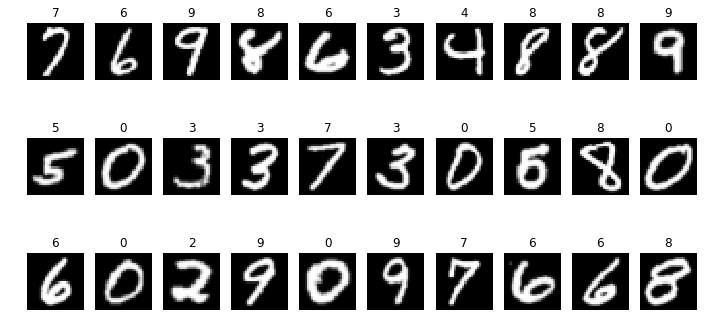

In [81]:
f = plt.figure(figsize=(12,6))

for i in range(n_view):
    sp = f.add_subplot(3, 10, i+1)
    sp.axis('Off')
    sp.set_title(preds_correct[i])
    img = imgs[i].astype('float32')
    plt.imshow(img[0], cmap='gray')

In [82]:
# ground truth labels
test_labels[idx]

array([7, 6, 9, 8, 6, 3, 4, 8, 8, 9, 5, 0, 3, 3, 7, 3, 0, 5, 8, 0, 6, 0, 2,
       9, 0, 9, 7, 6, 6, 8], dtype=uint8)

### a few incorrect labels at random

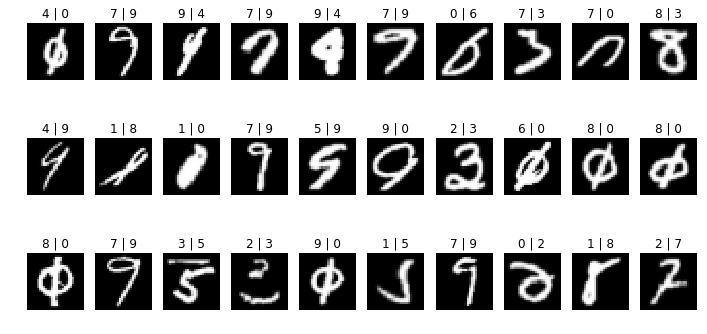

In [89]:
f = plt.figure(figsize=(12,6))

for i in range(n_view): 
    sp = f.add_subplot(3, 10, i+1)
    sp.axis('Off')
    sp.set_title("{} | {}".format(preds_incorrect[i],test_labels[idx_incorrect][i]))
    img = imgs_incorrect[i].astype('float32')
    plt.imshow(img[0], cmap='gray')

In [90]:
# ground truth labels
test_labels[idx_incorrect]

array([0, 9, 4, 9, 4, 9, 6, 3, 0, 3, 9, 8, 0, 9, 9, 0, 3, 0, 0, 0, 0, 9, 5,
       3, 0, 5, 9, 2, 8, 7], dtype=uint8)

# Print confusion matrix

Plot unnormalized and normalized confusion matrices. Code adapted from 
http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# calculate confusion matrix
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(test_labels, preds)

In [ ]:
import itertools

class_names = [i for i in range(10)]
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,5))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(20,5))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Save weights if model is accurate enough

In [ ]:
# save the weights for every classifier
for i, m in enumerate(models):
    m.save_weights("weights/weights_leaky_relu_model_0.22_additional_epochs"+str(i)+'.pkl')